In [41]:
!pip install sastrawi

In [42]:
!pip install tensorflow

In [43]:
import nltk
nltk.download('punkt_tab')
nltk.download('stopwords')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [70]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import csv
import string
import requests
import tensorflow as tf
from wordcloud import WordCloud
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from io import StringIO
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import CountVectorizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Embedding, Dense
from tensorflow.keras.utils import to_categorical

# Loading Dataset

In [45]:
reviews_df = pd.read_csv('review_product.csv')

## Display the first five rows of the reviews_df DataFrame.

In [46]:
reviews_df.head()

,Id,Username,Age,Skin_Description,Date,Rating,Review
0,1,memeladeng,30 - 34,"Combination, Medium, Neutral",4 days ago,4,"Formula lembutnya bebas alkohol, sangat aman u..."
1,2,abelianti,19 - 24,"Combination, Medium, Cool",11 Jan 2025,4,Micellar Water yang kandungan utama nya Niasor...
2,3,nadnaddd06,19 - 24,"Combination, Light, Neutral",04 Jan 2025,5,awal-awal pakai skincare untuk double cleasing...
3,4,sallsaaz,19 - 24,"Combination, Medium, Neutral",30 Dec 2024,4,"Kemasannya dr botol plastik ramping gitu, teks..."
4,5,niameiliani,19 - 24,"Combination, Medium Light, Neutral",25 Dec 2024,5,beli ini karena penasaran di review dan dipake...


##  An overview of the DataFrame structure, including the number of rows and columns, the data type for each column, and the number of non-null values in each column.

In [47]:
reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10009 entries, 0 to 10008
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Id                10009 non-null  int64 
 1   Username          10009 non-null  object
 2   Age               9988 non-null   object
 3   Skin_Description  10009 non-null  object
 4   Date              10009 non-null  object
 5   Rating            10009 non-null  int64 
 6   Review            10009 non-null  object
dtypes: int64(2), object(5)
memory usage: 547.5+ KB


There is an Age column with a null value which indicates that not all reviews have age data.

### Create a new DataFrame (clean_df) by deleting rows that have missing values (NaN) and remove duplicate rows from reviews_df

#### Deleting rows that have missing values (NaN) use dropna().

In [48]:
clean_df = reviews_df.dropna()

#### Remove duplicate rows from DataFrame clean_df clean_df = clean_df.drop_duplicates()

In [49]:
clean_df = clean_df.drop_duplicates()

#### Display dataframe information after clearing missing values

In [50]:
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9988 entries, 0 to 10008
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Id                9988 non-null   int64 
 1   Username          9988 non-null   object
 2   Age               9988 non-null   object
 3   Skin_Description  9988 non-null   object
 4   Date              9988 non-null   object
 5   Rating            9988 non-null   int64 
 6   Review            9988 non-null   object
dtypes: int64(2), object(5)
memory usage: 624.2+ KB


# Preprocessing Text

In [51]:
def cleanText(text):
  text = re.sub(r'@[A-Za-z0-9]+', '', text)
  text = re.sub(r'#[A-Za-z0-9]+', '', text)
  text = re.sub(r'RT[\s]', '', text)
  text = re.sub(r"http\S+", '', text)
  text = re.sub(r'[0-9]+', '', text)
  text = re.sub(r'[^\w\s]', '', text)

  text = text.replace('\n', ' ')
  text = text.translate(str.maketrans('', '', string.punctuation))
  text = text.strip(' ')
  return text

def foldingText(text):
  text = text.lower()
  return text

def tokenizingText(text):
  text = word_tokenize(text)
  return text

def filteringText(text):
  stopwords_idn = set(stopwords.words('indonesian'))
  stopwords_en = set(stopwords.words('english'))
  stopwords_idn.update(stopwords_en)
  stopwords_idn.update(['iya','yaa','gak','nya','na','sih','ku',"di","ga","ya","gaa","loh","kah","woi","woii","woy","deh","ngga","gitu","aja","tuh","nih","hehe", "gaada"])
  filtered = []
  for text1 in text:
    if text1 not in stopwords_idn:
      filtered.append(text1)

  text = filtered
  return text

def stemmingText(text):
  factory = StemmerFactory()
  stemmer = factory.create_stemmer()

  words = text.split()
  stemmed_words = [stemmer.stem(word) for word in words]
  stemmed_text = ' '.join(stemmed_words)
  return stemmed_text

def Sentence(list_word):
  sentence = ' '.join(word for word in list_word)
  return sentence

Delete a collection of slang words or informal words that are often used in daily conversations, especially on social media or online chats.

In [52]:
slangwords = {"@": "di", "abis": "habis", "wtb": "beli", "masi": "masih", "wts": "jual", "wtt": "tukar", "bgt": "banget", "maks": "maksimal", "pake": "pakai", "jd": "jadi", "senang": "seneng",
              "nyesel": "menyesal", "kalo": "kalau", "nyoba": "coba", "udh": "sudah", "tp": "tetapi", "krn": "karena", "emang": "memang", "yg": "yang",
              "jg": "juga", "udah": "sudah", "trus": "terus", "bener": "benar", "dapet": "dapat", "tau": "tahu", "kayak": "seperti", "karna": "karena"}
def slangWords(text):
  words = text.split()
  fixed_words = []

  for word in words:
    if word.lower() in slangwords:
      fixed_words.append(slangwords[word.lower()])
    else:
      fixed_words.append(word)

  fixed_text = ' '.join(fixed_words)
  return fixed_text
  fixed_words = []

  for word in words:
    if word.lower() in slangwords:
      fixed_words.append(slangwords[word.lower()])
    else:
      fixed_words.append(word)

    fixed_text = ' '.join(fixed_words)
    return fixed_text

In [53]:
# Cleans the text and stores it in the 'txt_clean' field
clean_df['txt_clean'] = clean_df['Review'].apply(cleanText)

# Convert letters in text to lowercase and store them in 'txt_folding'
clean_df['txt_folding'] = clean_df['txt_clean'].apply(foldingText)

# Replace slang words with standard words and store them in 'txt_slangwords'
clean_df['txt_slangwords'] = clean_df['txt_folding'].apply(slangWords)

# Perform stemming
# clean_df['txt_stemmed'] = clean_df['txt_slangwords'].apply(stemmingText)

# Break the text into tokens (words) and store them in 'txt_tokenizing'
clean_df['txt_tokenizing'] = clean_df['txt_slangwords'].apply(tokenizingText)

# Removes stop words (common words) and stores them in 'txt_stopword'
clean_df['txt_stopword'] = clean_df['txt_tokenizing'].apply(filteringText)

# Concatenate the tokens into a sentence and store it in 'last_text'
clean_df['last_text'] = clean_df['txt_stopword'].apply(Sentence)

In [54]:
clean_df.head()

,Id,Username,Age,Skin_Description,Date,Rating,Review,txt_clean,txt_folding,txt_slangwords,txt_tokenizing,txt_stopword,last_text
0,1,memeladeng,30 - 34,"Combination, Medium, Neutral",4 days ago,4,"Formula lembutnya bebas alkohol, sangat aman u...",Formula lembutnya bebas alkohol sangat aman un...,formula lembutnya bebas alkohol sangat aman un...,formula lembutnya bebas alkohol sangat aman un...,"[formula, lembutnya, bebas, alkohol, sangat, a...","[formula, lembutnya, bebas, alkohol, aman, pem...",formula lembutnya bebas alkohol aman pemakaian...
1,2,abelianti,19 - 24,"Combination, Medium, Cool",11 Jan 2025,4,Micellar Water yang kandungan utama nya Niasor...,Micellar Water yang kandungan utama nya Niasor...,micellar water yang kandungan utama nya niasor...,micellar water yang kandungan utama nya niasor...,"[micellar, water, yang, kandungan, utama, nya,...","[micellar, water, kandungan, utama, niasorcino...",micellar water kandungan utama niasorcinol ber...
2,3,nadnaddd06,19 - 24,"Combination, Light, Neutral",04 Jan 2025,5,awal-awal pakai skincare untuk double cleasing...,awalawal pakai skincare untuk double cleasing ...,awalawal pakai skincare untuk double cleasing ...,awalawal pakai skincare untuk double cleasing ...,"[awalawal, pakai, skincare, untuk, double, cle...","[awalawal, pakai, skincare, double, cleasing, ...",awalawal pakai skincare double cleasing pakai ...
3,4,sallsaaz,19 - 24,"Combination, Medium, Neutral",30 Dec 2024,4,"Kemasannya dr botol plastik ramping gitu, teks...",Kemasannya dr botol plastik ramping gitu tekst...,kemasannya dr botol plastik ramping gitu tekst...,kemasannya dr botol plastik ramping gitu tekst...,"[kemasannya, dr, botol, plastik, ramping, gitu...","[kemasannya, dr, botol, plastik, ramping, teks...",kemasannya dr botol plastik ramping teksturnya...
4,5,niameiliani,19 - 24,"Combination, Medium Light, Neutral",25 Dec 2024,5,beli ini karena penasaran di review dan dipake...,beli ini karena penasaran di review dan dipake...,beli ini karena penasaran di review dan dipake...,beli ini karena penasaran di review dan dipake...,"[beli, ini, karena, penasaran, di, review, dan...","[beli, penasaran, review, dipake, nanda, arsyn...",beli penasaran review dipake nanda arsynta mur...


# Labeling

In [55]:
lexicon_positive = dict()

response = requests.get('https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_positive.csv')

if response.status_code == 200:
  reader = csv.reader(StringIO(response.text), delimiter=',')

  for row in reader:
    lexicon_positive[row[0]] = int(row[1])

else:
  print("Failed to fetch positive lexicon data")

lexicon_negative = dict()

response = requests.get('https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_negative.csv')

if response.status_code == 200:
  reader = csv.reader(StringIO(response.text), delimiter=',')

  for row in reader:
    lexicon_negative[row[0]] = int(row[1])

else:
  print("Failed to fetch negative lexicon data")

In [56]:
# Function to determine the sentiment polarity of a tweet
def sentiment_analysis_lexicon_idn(text):
  score = 0

  for word in text:
    if(word in lexicon_positive):
      # If the word is in the positive dictionary, add its score to the sentiment score
      score = score + lexicon_positive[word]

  for word in text:
    if(word in lexicon_negative):
      # If the word is in the negative dictionary, reduce its score from the sentiment score
      score = score + lexicon_negative[word]

  polarity = ''

  if (score > 2):
    polarity = 'positive'

  elif (score < -6):
    polarity = 'negative'

  else:
    polarity = 'neutral'

  return score, polarity

In [57]:
results = clean_df['txt_stopword'].apply(sentiment_analysis_lexicon_idn)
results = list(zip(*results))
clean_df['polarity_score'] = results[0]
clean_df['polarity'] = results[1]
print(clean_df['polarity'].value_counts())

polarity
positive    4073
neutral     3991
negative    1924
Name: count, dtype: int64


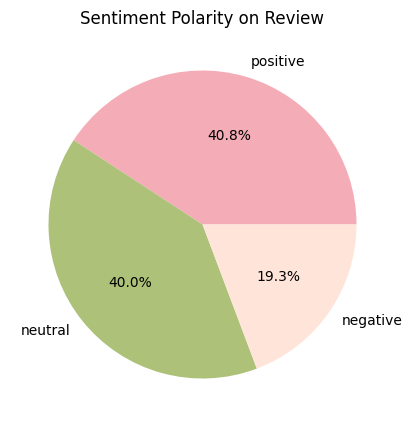

In [58]:
polarity_counts = clean_df['polarity'].value_counts(normalize=True) * 100

plt.figure(figsize=(5, 5))
plt.pie(polarity_counts, labels=polarity_counts.index, autopct='%1.1f%%', colors=['#F4ACB7','#ADC178','#FFE5D9'])

plt.title('Sentiment Polarity on Review')
plt.show()

# Label Exploration

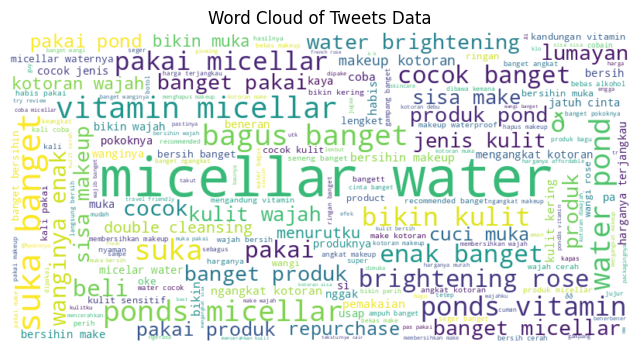

In [59]:
# Join all text in the 'last_text' column
text_all = ' '.join(clean_df['last_text'])

# Create a WordCloud for the whole text
wordcloud_all = WordCloud(width=800, height=400, background_color='white').generate(text_all)

# Display the WordCloud
plt.figure(figsize=(8, 5))
plt.imshow(wordcloud_all, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Tweets Data')
plt.show()

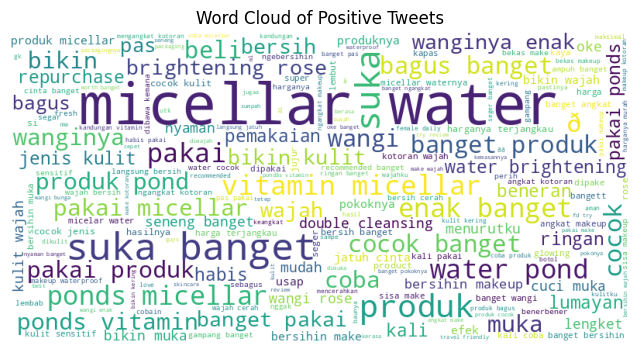

In [60]:
positive_text = ' '.join(clean_df[clean_df['polarity'] == 'positive']['last_text'])

wordcloud_positive = WordCloud(width=800, height=400, background_color='white').generate(positive_text)

plt.figure(figsize=(8,5))
plt.imshow(wordcloud_positive)
plt.axis('off')
plt.title('Word Cloud of Positive Tweets')
plt.show()

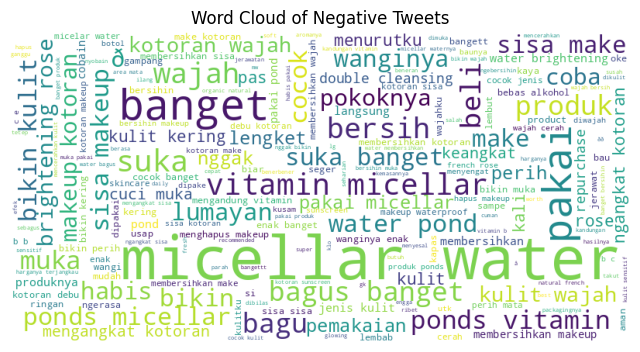

In [61]:
negative_text = ' '.join(clean_df[clean_df['polarity'] == 'negative']['last_text'])

wordcloud_negative = WordCloud(width=800, height=400, background_color='white').generate(negative_text)

plt.figure(figsize=(8,5))
plt.imshow(wordcloud_negative)
plt.axis('off')
plt.title('Word Cloud of Negative Tweets')
plt.show()

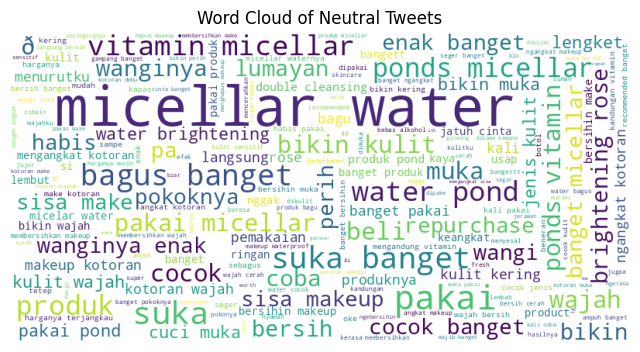

In [62]:
neutral_text = ' '.join(clean_df[clean_df['polarity'] == 'neutral']['last_text'])

wordcloud_neutral= WordCloud(width=800, height=400, background_color='white').generate(neutral_text)

plt.figure(figsize=(8,5))
plt.imshow(wordcloud_neutral)
plt.axis('off')
plt.title('Word Cloud of Neutral Tweets')
plt.show()

**WordCloud in General:**

This visualization displays all words that appear in the dataframe with all sentiment categories.
This can give an overview of the products that are frequently mentioned in the dataframe.

**WordCloud for Positive Tweets:**

This WordCloud shows words derived from tweets or texts with positive sentiment.
The words that appear are likely to be related to positive words that indicate user satisfaction with the product, such as “bagus”, “enak”, or “suka”.

**WordCloud for Negative Tweets:**

This WordCloud displays words from tweets or texts with negative sentiments.
The words that appear are likely related to complaints or dissatisfaction with the product, such as “perih”, “menyesal”, or “susah”.

**WordCloud for Neutral Tweets:**

This WordCloud displays words from tweets or texts with neutral sentiments.
The words that appear are likely words that do not show positive or negative tendencies.

**Conclusion:**

This WordCloud visualization helps in understanding the pattern of words in the dataframe based on each category. By seeing the difference between neutral, positive and negative sentiments, we can understand how customers feel about a product overall. This can provide useful insights for product improvement.

# Data Splitting, Feature Extraction and Modeling

In [63]:
X = clean_df['last_text']
y = clean_df['polarity']

# Feature extraction using Count Vectorizer
count_vectorizer = CountVectorizer(max_features=1500, min_df=16, max_df=0.8)
X_count = count_vectorizer.fit_transform(X)

# Training and test data split
X_train, X_test, y_train, y_test = train_test_split(X_count, y, test_size=0.2, random_state=42)

# Build SVM model
svm_model = SVC(C=0.65, kernel='linear', gamma='scale')
svm_model.fit(X_train, y_train)

# Prediction and evaluation
y_pred_train_svm = svm_model.predict(X_train)
y_pred_test_svm = svm_model.predict(X_test)

accuracy_train_svm = accuracy_score(y_train, y_pred_train_svm)
accuracy_test_svm = accuracy_score(y_test, y_pred_test_svm)

print("Training: SVM, Feature Extraction: Count Vectorizer, Data Split: 80/20")
print(f"SVM - accuracy_train: {accuracy_train_svm:.4f}")
print(f"SVM - accuracy_test: {accuracy_test_svm:.4f}")

Training: SVM, Feature Extraction: Count Vectorizer, Data Split: 80/20
SVM - accuracy_train: 0.9548
SVM - accuracy_test: 0.8534


The SVM model with Count Vectorizer as Feature Extraction technique and 80/20 split data shows good results in training accuracy, which is 0.9548 (95.48%). This shows that the model is very good at recognizing patterns from training data. However, the accuracy on the test data is 0.8534 (85.34%), which is lower than the accuracy on the training data.

In [94]:
# Dense Neural Network (DNN)
y2 = clean_df['polarity']
# Converting labels
label_encoder = LabelEncoder()
y_encode = label_encoder.fit_transform(y2)
y_encode = to_categorical(y_encode, num_classes=3)

# Training and test data split
X_train_dnn, X_test_dnn, y_train_dnn, y_test_dnn = train_test_split(X_count.toarray(), y_encode, test_size=0.2, random_state=42)

# Building a model
model_dnn = Sequential()
model_dnn.add(Dense(128, input_dim=X_count.shape[1], activation='relu'))
model_dnn.add(Dense(3, activation='softmax'))

# Developing a model
model_dnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Training the model
model_dnn.fit(X_train_dnn, y_train_dnn, epochs=8, batch_size=64, validation_data=(X_test_dnn, y_test_dnn))

accuracy_train_dnn = model_dnn.evaluate(X_train_dnn, y_train_dnn, verbose=0)
accuracy_test_dnn = model_dnn.evaluate(X_test_dnn, y_test_dnn, verbose=0)

print("Training: DNN, Feature Extraction: Count Vectorizer, Data Split: 80/20")
print(f"DNN - accuracy_train: {accuracy_train_dnn[1]:.4f}")
print(f"DNN - accuracy_test: {accuracy_test_dnn[1]:.4f}")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/8
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.5251 - loss: 0.9469 - val_accuracy: 0.7523 - val_loss: 0.6133
Epoch 2/8
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8284 - loss: 0.4898 - val_accuracy: 0.8023 - val_loss: 0.4663
Epoch 3/8
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9017 - loss: 0.3171 - val_accuracy: 0.8293 - val_loss: 0.4124
Epoch 4/8
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9422 - loss: 0.2287 - val_accuracy: 0.8373 - val_loss: 0.3920
Epoch 5/8
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9562 - loss: 0.1767 - val_accuracy: 0.8428 - val_loss: 0.3918
Epoch 6/8
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9779 - loss: 0.1304 - val_accuracy: 0.8373 - val_loss: 0.4005
Epoch 7/8
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9832 - loss: 0.1012 - val_accuracy: 0.8473 - val_loss: 0.4081
Epoch 8/8
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9902 - loss: 0.0783 - val_accuracy: 0.8504 - v

The DNN (Deep Neural Network) model with Count Vectorizer as Feature Extraction technique and 80/20 split data shows good results in training accuracy, which is 0.9950 (99.50%). This shows that the model is very good at recognizing patterns from training data. However, the accuracy on the test data is 0.8504 (85.04%), which is lower than the accuracy on the training data.